In [64]:
from nilearn import image, input_data, masking, plotting, signal
from nilearn.datasets import MNI152_FILE_PATH
from nilearn.plotting import plot_roi, plot_epi, show
import numpy as np
from numpy import tile, sinc, dot, newaxis
import matplotlib.pylab as plt
from scipy.fftpack import fft, fftfreq, fftshift
from scipy.signal import detrend, resample
from scipy.stats import zscore
from utilities import files
from astropy.timeseries import LombScargle
import os.path as op
%matplotlib qt

In [87]:
path = "/home/mszul/datasets/braindyn_localizer"
participants = files.get_folders_files(path)[0]
participant = participants[0]
_id = participant.split("/")[-1]

mask = "/home/mszul/git/BrainDyn_ANALYSIS/masks/hocp-Occipital_Pole.nii.gz"
nifti = op.join(
    participant, 
    "func", 
    "{}_task-flicker_dir-AP_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz".format(_id)
)
brain_mask = op.join(
    participant,
    "func",
    "{}_task-flicker_dir-AP_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz".format(_id)
)
t1 = op.join(
    participant,
    "anat",
    "{}_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz".format(_id)
)

In [4]:
def sinc_interp(x, s, u):
    """
    Interpolates x, sampled at "s" instants
    Output y is sampled at "u" instants ("u" for "upsampled")
    
    from Matlab:
    http://phaseportrait.blogspot.com/2008/06/sinc-interpolation-in-matlab.html
    source: https://gist.github.com/endolith/1297227
    https://en.wikipedia.org/wiki/Whittaker%E2%80%93Shannon_interpolation_formula
    """
    
    if len(x) != len(s):
        raise Exception('x and s must be the same length')
    
    # Find the period    
    T = s[1] - s[0]
    
    sincM = tile(u, (len(s), 1)) - tile(s[:, newaxis], (1, len(u)))
    y = dot(x, sinc(sincM/T))
    return y

In [78]:
flicker = image.smooth_img(nifti, fwhm=None)
roi_op = image.smooth_img("/home/mszul/git/BrainDyn_ANALYSIS/masks/hocp-Occipital_Pole.nii.gz", fwhm=None)
roi_op = image.resample_to_img(roi_op, flicker, fill_value=0, clip=True, interpolation="nearest")
roi_ffg = image.smooth_img("/home/mszul/git/BrainDyn_ANALYSIS/masks/hocp-Occipital_Fusiform_Gyrus.nii.gz", fwhm=None)
roi_ffg = image.resample_to_img(roi_ffg, flicker, fill_value=0, clip=True, interpolation="nearest")
mean_flicker = image.mean_img(flicker)

/home/mszul/miniconda3/envs/mne/lib/python3.9/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



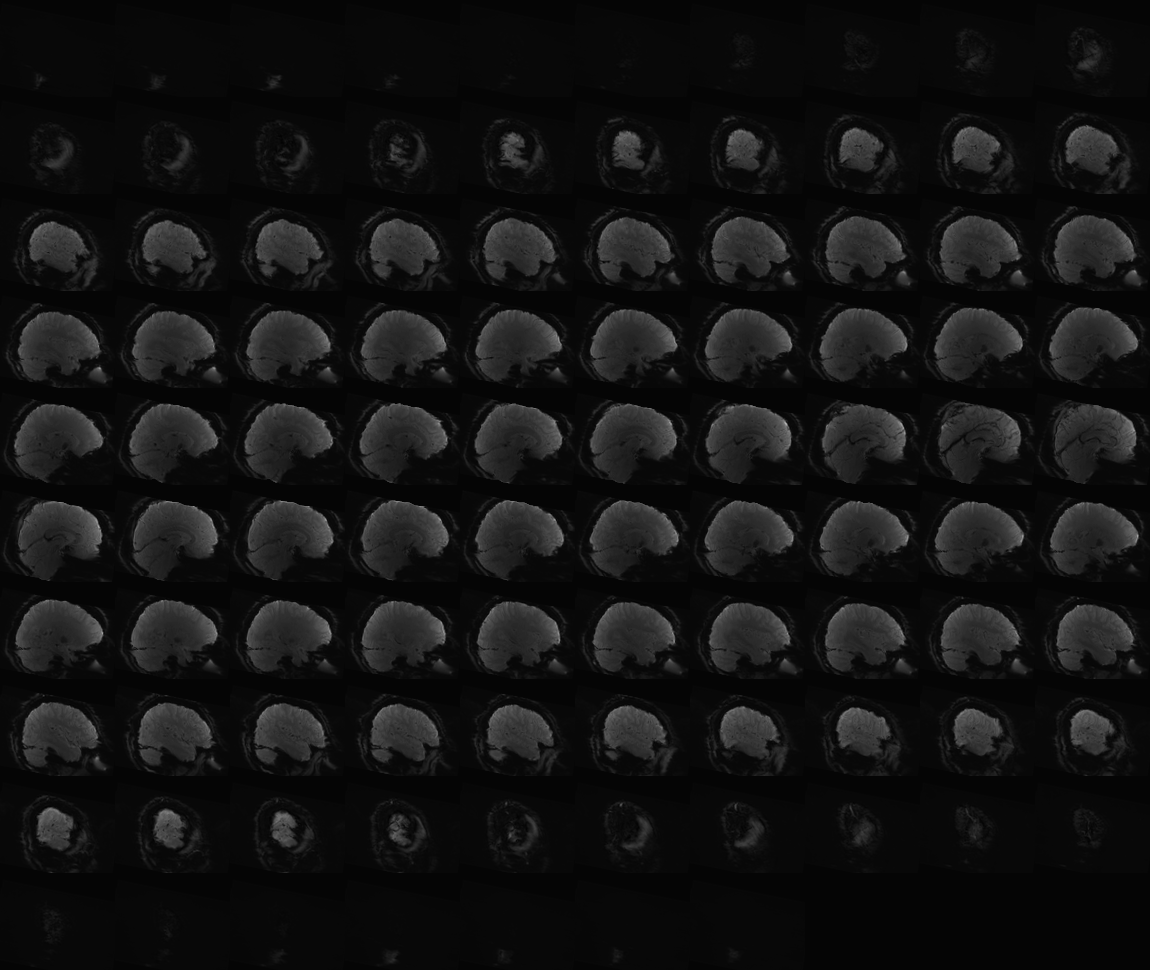
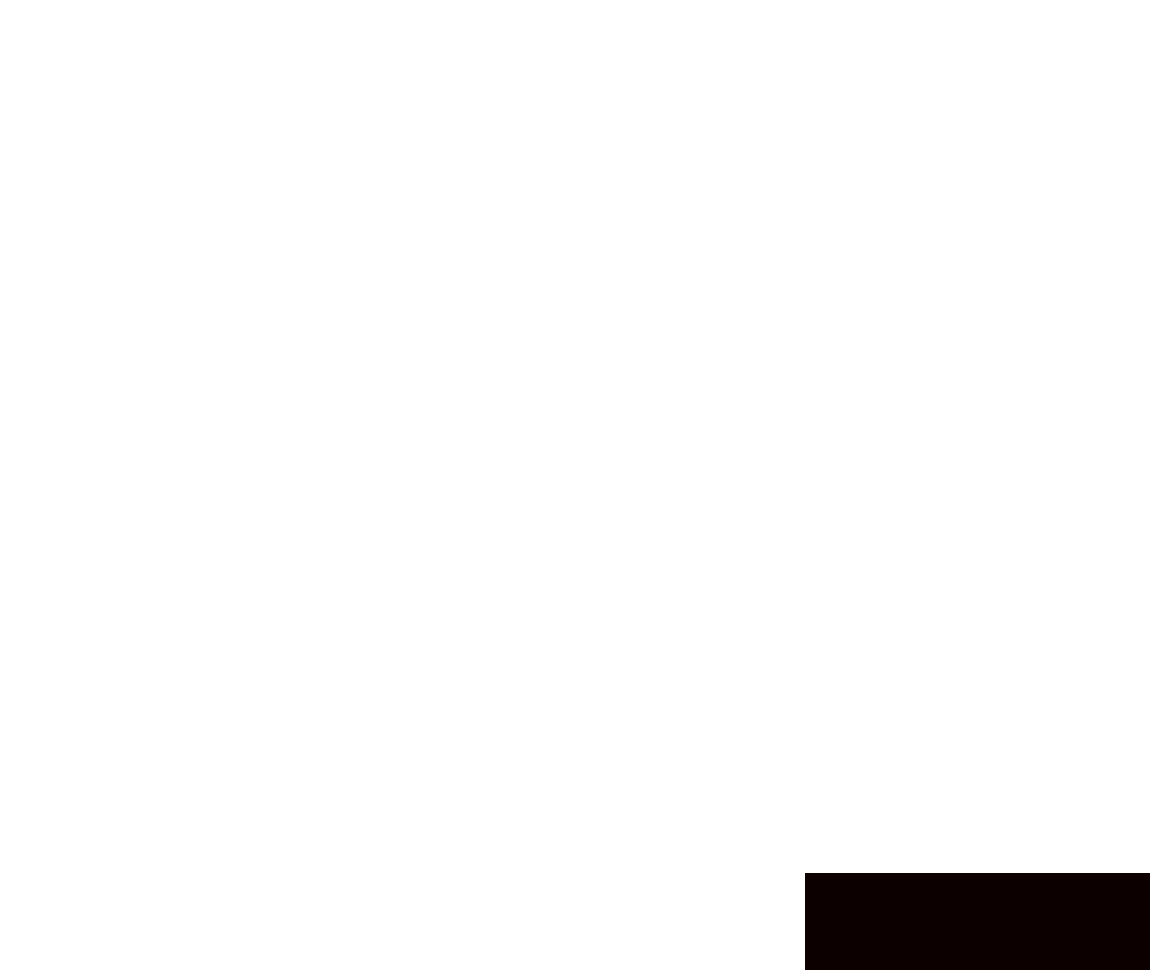

In [79]:
plotting.view_img(roi_op, threshold=.9999, bg_img=mean_flicker, black_bg=True)


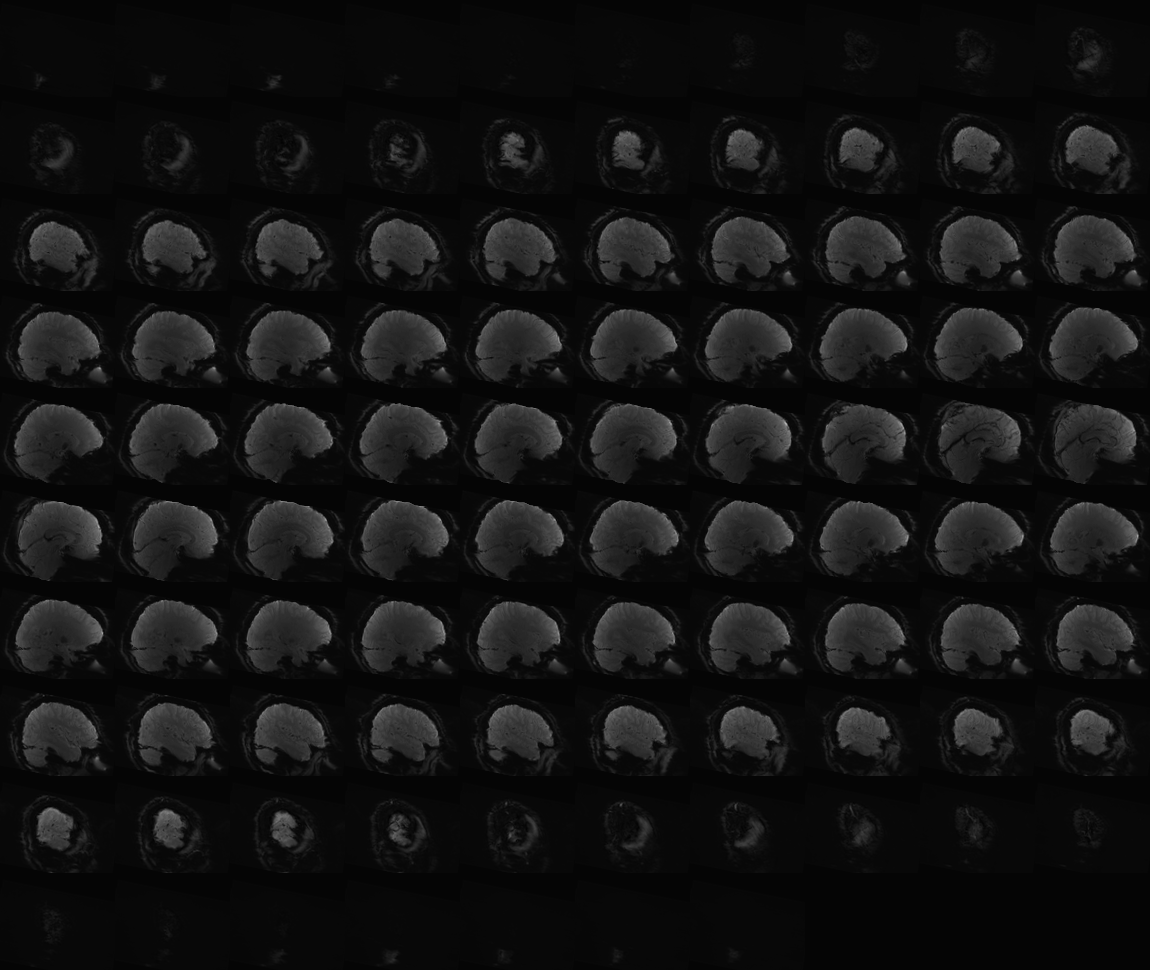
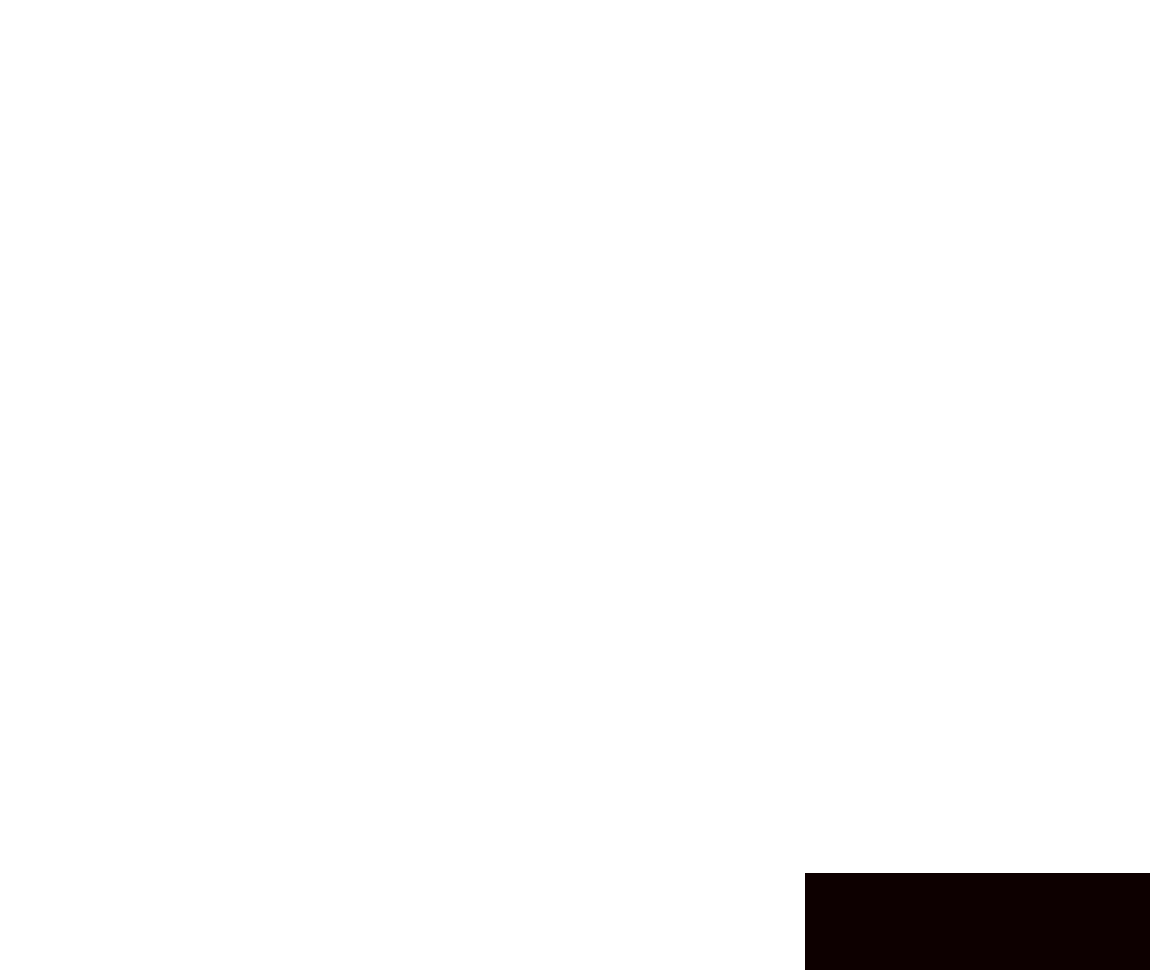

In [80]:
plotting.view_img(roi_ffg, threshold=.9999, bg_img=mean_flicker, black_bg=True)

In [81]:
flicker_voxels = masking.apply_mask(flicker, roi_ffg, smoothing_fwhm=3)
time = np.arange(flicker_voxels.shape[0])*1.3
nyquist_freq = (1/1.3)/2
flicker_voxels = signal._detrend(flicker_voxels, type="linear")
fft_freq_targ = np.round(np.arange(-np.round(nyquist_freq, 1), np.round(nyquist_freq, 1), 0.0005), 4)

In [66]:
# sinc interpolated power spectrum

timecourse = flicker_voxels[:, 234]
fft_Y = fft(zscore(timecourse), axis=0)
fft_FREQ = fftfreq(fft_Y.shape[0], 1.3)
fft_FREQ = fftshift(fft_FREQ)
fft_Y = fftshift(np.single(np.abs(fft_Y)))

f, ax = plt.subplots(figsize=(16, 6))
ax.plot(fft_FREQ, fft_Y, c="black", lw=0.5)
ax.scatter(fft_FREQ, fft_Y, marker="o", s=3)


fft_interp = sinc_interp(fft_Y, fft_FREQ, fft_freq_targ)

ax.plot(fft_freq_targ, fft_interp, c="red", lw=0.5)
ax.scatter(fft_freq_targ, fft_interp, c="red", marker="o", s=3)

for i in range(1,10):
    ax.axvline(i*0.0385, lw=0.5, c="green")
    ax.axvspan(i*0.0385+20*0.0005, i*0.0385-20*0.0005, color="green", alpha=0.2)
    below = np.where((fft_freq_targ >= i*0.0385-20*0.0005) & (fft_freq_targ < i*0.0385))[0]
    above = np.where((fft_freq_targ <= i*0.0385+20*0.0005) & (fft_freq_targ > i*0.0385))[0]
    target_freq = np.where(fft_freq_targ == np.round(i*0.0385, 4))[0]

ax.set_xlim(0.0, nyquist_freq);

In [86]:
# zeropadded
timecourse = flicker_voxels[:, 234]
fft_Y = fft(zscore(timecourse), axis=0)
fft_FREQ = fftfreq(fft_Y.shape[0], 1.3)
fft_FREQ = fftshift(fft_FREQ)
fft_Y = fftshift(np.single(np.abs(fft_Y)))
f, ax = plt.subplots(figsize=(16, 6))
# ax.plot(fft_FREQ, fft_Y/(1/1.3), c="black", lw=0.5)
# ax.scatter(fft_FREQ, fft_Y/(1/1.3), marker="o", color="black", s=3)


padded_timecourse = np.pad(timecourse, (0,770))
# padded_timecourse = np.pad(timecourse, (0,3847))
fft_Y = fft(zscore(padded_timecourse), axis=0)
fft_FREQ = fftfreq(fft_Y.shape[0], 1.3)
fft_FREQ = fftshift(fft_FREQ)
fft_Y = fftshift(np.single(np.abs(fft_Y)))
ax.plot(fft_FREQ, fft_Y/(1/0.15), c="red", lw=0.5)
ax.scatter(fft_FREQ, fft_Y/(1/0.15), marker="o", color="red", s=3)

for i in range(1,10):
    ax.axvline(i*0.0375, lw=0.5, c="green")
    ax.axvspan(i*0.0375+20*0.0005, i*0.0375-20*0.0005, color="green", alpha=0.2)
    below = np.where((fft_freq_targ >= i*0.0375-20*0.0005) & (fft_freq_targ < i*0.0375))[0]
    above = np.where((fft_freq_targ <= i*0.0375+20*0.0005) & (fft_freq_targ > i*0.0375))[0]
    target_freq = np.where(fft_freq_targ == np.round(i*0.0375, 4))[0]

ax.set_xlim(0.0, nyquist_freq)

(0.0, 0.3846153846153846)

In [83]:
timecourse.shape

(215,)

In [73]:
timecourse = flicker_voxels[:, 234]
fft_Y = fft(zscore(timecourse), axis=0)
fft_FREQ = fftfreq(fft_Y.shape[0], 1.3)
fft_FREQ = fftshift(fft_FREQ)
fft_Y = fftshift(np.single(np.abs(fft_Y)))
f, ax = plt.subplots(figsize=(16, 6))
# ax.plot(fft_FREQ, fft_Y/(1/1.3), c="black", lw=0.5)
# ax.scatter(fft_FREQ, fft_Y/(1/1.3), marker="o", color="black", s=3)

time = np.arange(500) * 1.3
targ_freq = np.round(np.arange(0, np.round(nyquist_freq, 1), 0.0005), 4)
LS_PSD = LombScargle(time, timecourse).power(targ_freq)
LS_PSD = np.nan_to_num(LS_PSD, nan=0)

ax.plot(targ_freq, LS_PSD, c="red", lw=0.5)
ax.scatter(targ_freq, LS_PSD, marker="o", color="red", s=3)

for i in range(1,10):
    ax.axvline(i*0.0375, lw=0.5, c="green")
    ax.axvspan(i*0.0375+20*0.0005, i*0.0375-20*0.0005, color="green", alpha=0.2)
    below = np.where((fft_freq_targ >= i*0.0375-20*0.0005) & (fft_freq_targ < i*0.0375))[0]
    above = np.where((fft_freq_targ <= i*0.0375+20*0.0005) & (fft_freq_targ > i*0.0375))[0]
    target_freq = np.where(fft_freq_targ == np.round(i*0.0375, 4))[0]

ax.set_xlim(0.0, nyquist_freq)
ax.set_ylim(-0.001, 0.02);

/home/mszul/miniconda3/envs/mne/lib/python3.9/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:93: RuntimeWarning: invalid value encountered in true_divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))


In [33]:
# not needed
flicker_voxels = masking.apply_mask(flicker, roi_ffg, smoothing_fwhm=3)
time = np.arange(flicker_voxels.shape[0])*1.3
nyquist_freq = (1/1.3)/2
flicker_voxels = signal._detrend(flicker_voxels, type="linear")
fft_freq_targ = np.round(np.arange(-np.round(nyquist_freq, 1), np.round(nyquist_freq, 1), 0.0005), 4)

zscore_all = []
for voxel in range(flicker_voxels.shape[1]):
    timecourse = flicker_voxels[:, voxel]
    fft_Y = fft(zscore(timecourse), axis=0)
    fft_FREQ = fftfreq(fft_Y.shape[0], 1.3)
    fft_FREQ = fftshift(fft_FREQ)
    fft_Y = fftshift(np.single(np.abs(fft_Y)))
    fft_interp = sinc_interp(fft_Y, fft_FREQ, fft_freq_targ)
    zscore_list = []
    for i in range(1,10):
        below = np.where((fft_freq_targ >= i*0.0385-20*0.0005) & (fft_freq_targ < i*0.0385))[0]
        above = np.where((fft_freq_targ <= i*0.0385+20*0.0005) & (fft_freq_targ > i*0.0385))[0]
        target_freq = np.where(fft_freq_targ == np.round(i*0.0385, 4))[0]
        around = np.concatenate([above, below])
        around.sort()
        sel = np.take(fft_interp, around, axis=0)
        tar = np.take(fft_interp, target_freq, axis=0)
        zscored_tar = (tar - sel.mean())/sel.std()
        zscore_list.append(zscored_tar[0])
    zscore_all.append(zscore_list)

np.save("zscore_ffg.npy", np.array(zscore_all))

In [68]:
fft_freq_targ.shape

(800,)

In [34]:
# not needed
flicker_voxels = masking.apply_mask(flicker, roi_op, smoothing_fwhm=3)
time = np.arange(flicker_voxels.shape[0])*1.3
nyquist_freq = (1/1.3)/2
flicker_voxels = signal._detrend(flicker_voxels, type="linear")
fft_freq_targ = np.round(np.arange(-np.round(nyquist_freq, 1), np.round(nyquist_freq, 1), 0.0005), 4)

zscore_all = []
for voxel in range(flicker_voxels.shape[1]):
    timecourse = flicker_voxels[:, voxel]
    fft_Y = fft(zscore(timecourse), axis=0)
    fft_FREQ = fftfreq(fft_Y.shape[0], 1.3)
    fft_FREQ = fftshift(fft_FREQ)
    fft_Y = fftshift(np.single(np.abs(fft_Y)))
    fft_interp = sinc_interp(fft_Y, fft_FREQ, fft_freq_targ)
    zscore_list = []
    for i in range(1,10):
        below = np.where((fft_freq_targ >= i*0.0385-20*0.0005) & (fft_freq_targ < i*0.0385))[0]
        above = np.where((fft_freq_targ <= i*0.0385+20*0.0005) & (fft_freq_targ > i*0.0385))[0]
        target_freq = np.where(fft_freq_targ == np.round(i*0.0385, 4))[0]
        around = np.concatenate([above, below])
        around.sort()
        sel = np.take(fft_interp, around, axis=0)
        tar = np.take(fft_interp, target_freq, axis=0)
        zscored_tar = (tar - sel.mean())/sel.std()
        zscore_list.append(zscored_tar[0])
    zscore_all.append(zscore_list)

np.save("zscore_op.npy", np.array(zscore_all))

In [35]:
# Lomb Scargle
flicker_voxels = masking.apply_mask(flicker, roi_ffg, smoothing_fwhm=3)
time = np.arange(flicker_voxels.shape[0])*1.3
nyquist_freq = (1/1.3)/2
flicker_voxels = signal._detrend(flicker_voxels, type="linear")
fft_freq_targ = np.round(np.arange(-np.round(nyquist_freq, 1), np.round(nyquist_freq, 1), 0.0005), 4)

zscore_all = []
for voxel in range(flicker_voxels.shape[1]):
    timecourse = flicker_voxels[:, voxel]
    time = np.arange(500) * 1.3
    fft_freq_targ = np.round(np.arange(0, np.round(nyquist_freq, 1), 0.0005), 4)
    fft_interp = LombScargle(time, timecourse).power(targ_freq)
    fft_interp = np.nan_to_num(fft_interp, nan=0)
    zscore_list = []
    for i in range(1,10):
        below = np.where((fft_freq_targ >= i*0.0385-20*0.0005) & (fft_freq_targ < i*0.0385))[0]
        above = np.where((fft_freq_targ <= i*0.0385+20*0.0005) & (fft_freq_targ > i*0.0385))[0]
        target_freq = np.where(fft_freq_targ == np.round(i*0.0385, 4))[0]
        around = np.concatenate([above, below])
        around.sort()
        sel = np.take(fft_interp, around, axis=0)
        tar = np.take(fft_interp, target_freq, axis=0)
        zscored_tar = (tar - sel.mean())/sel.std()
        zscore_list.append(zscored_tar[0])
    zscore_all.append(zscore_list)

np.save("zscore_ffg_LS.npy", np.array(zscore_all))

In [36]:
# Lomb Scargle
flicker_voxels = masking.apply_mask(flicker, roi_op, smoothing_fwhm=3)
time = np.arange(flicker_voxels.shape[0])*1.3
nyquist_freq = (1/1.3)/2
flicker_voxels = signal._detrend(flicker_voxels, type="linear")
fft_freq_targ = np.round(np.arange(-np.round(nyquist_freq, 1), np.round(nyquist_freq, 1), 0.0005), 4)

zscore_all = []
for voxel in range(flicker_voxels.shape[1]):
    timecourse = flicker_voxels[:, voxel]
    time = np.arange(500) * 1.3
    fft_freq_targ = np.round(np.arange(0, np.round(nyquist_freq, 1), 0.0005), 4)
    fft_interp = LombScargle(time, timecourse).power(targ_freq)
    fft_interp = np.nan_to_num(fft_interp, nan=0)
    zscore_list = []
    for i in range(1,10):
        below = np.where((fft_freq_targ >= i*0.0385-20*0.0005) & (fft_freq_targ < i*0.0385))[0]
        above = np.where((fft_freq_targ <= i*0.0385+20*0.0005) & (fft_freq_targ > i*0.0385))[0]
        target_freq = np.where(fft_freq_targ == np.round(i*0.0385, 4))[0]
        around = np.concatenate([above, below])
        around.sort()
        sel = np.take(fft_interp, around, axis=0)
        tar = np.take(fft_interp, target_freq, axis=0)
        zscored_tar = (tar - sel.mean())/sel.std()
        zscore_list.append(zscored_tar[0])
    zscore_all.append(zscore_list)

np.save("zscore_op_LS.npy", np.array(zscore_all))

(10688, 9)


/home/mszul/miniconda3/envs/mne/lib/python3.9/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



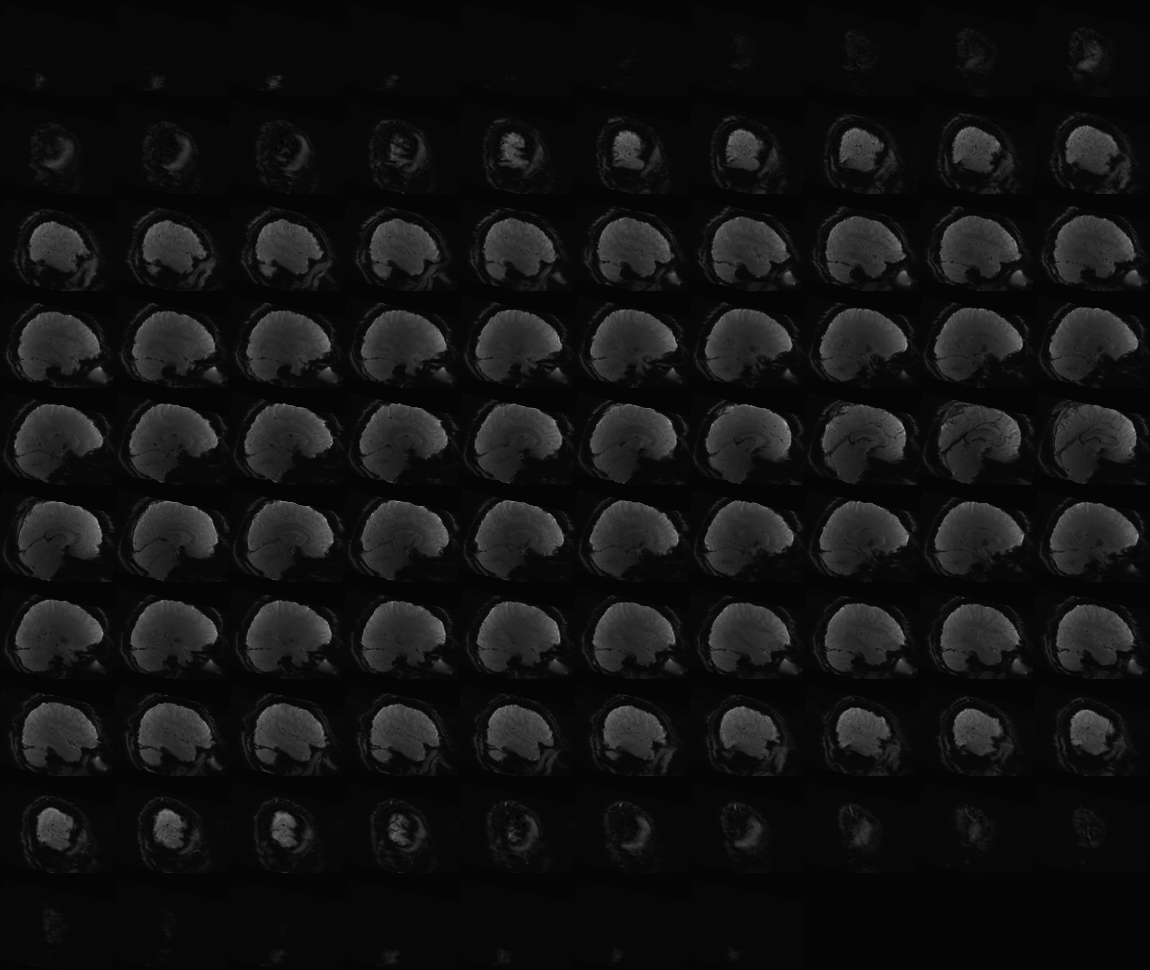
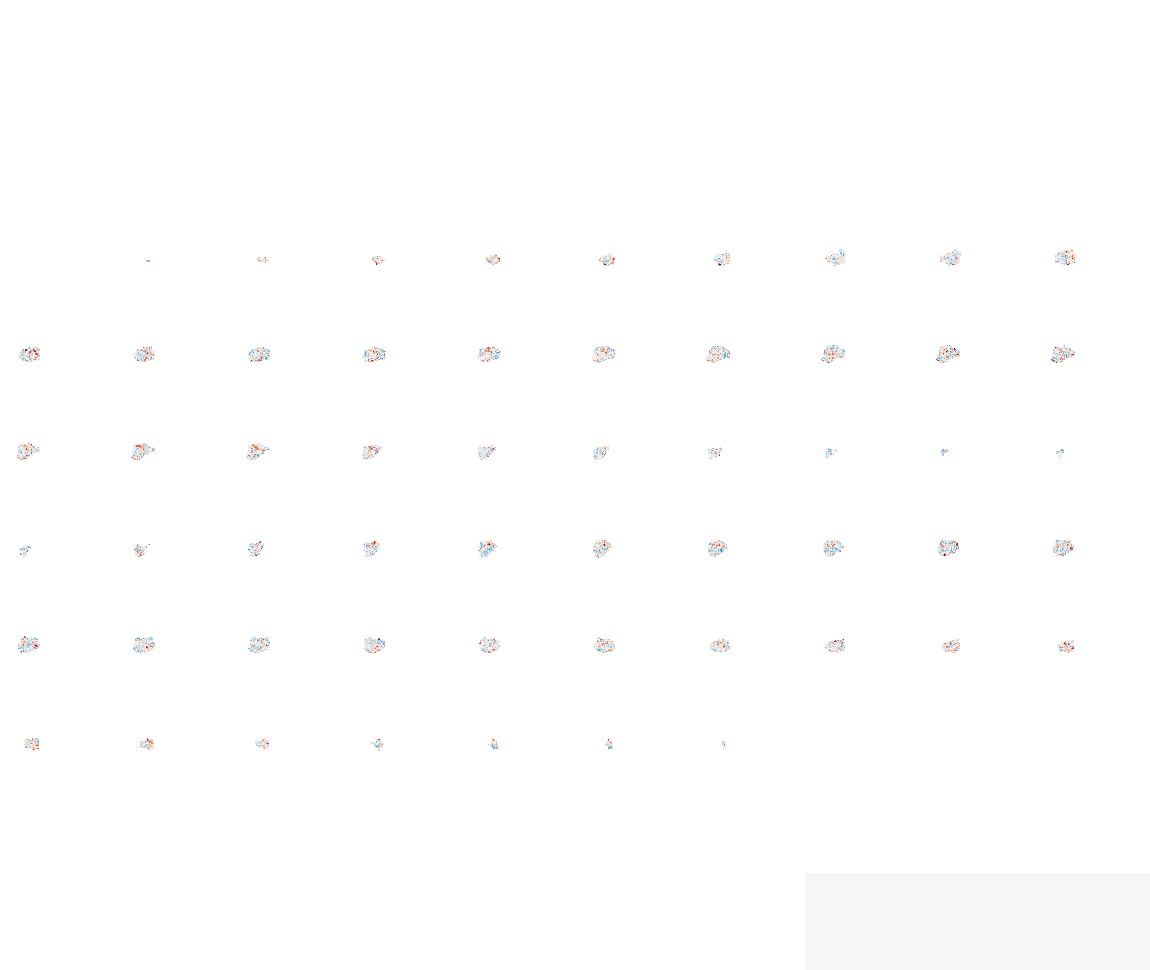

In [67]:
occipital_lobe_results = np.load("zscore_ffg.npy")
print(occipital_lobe_results.shape)
# mask_ = masking.unmask(np.sum(occipital_lobe_results, axis=1), roi_ffg)
mask_ = masking.unmask(occipital_lobe_results[:,0], roi_ffg)

plotting.view_img(mask_, bg_img=mean_flicker, cmap="RdBu_r", threshold=0.0001, black_bg=True, colorbar=True)

(15486, 9)



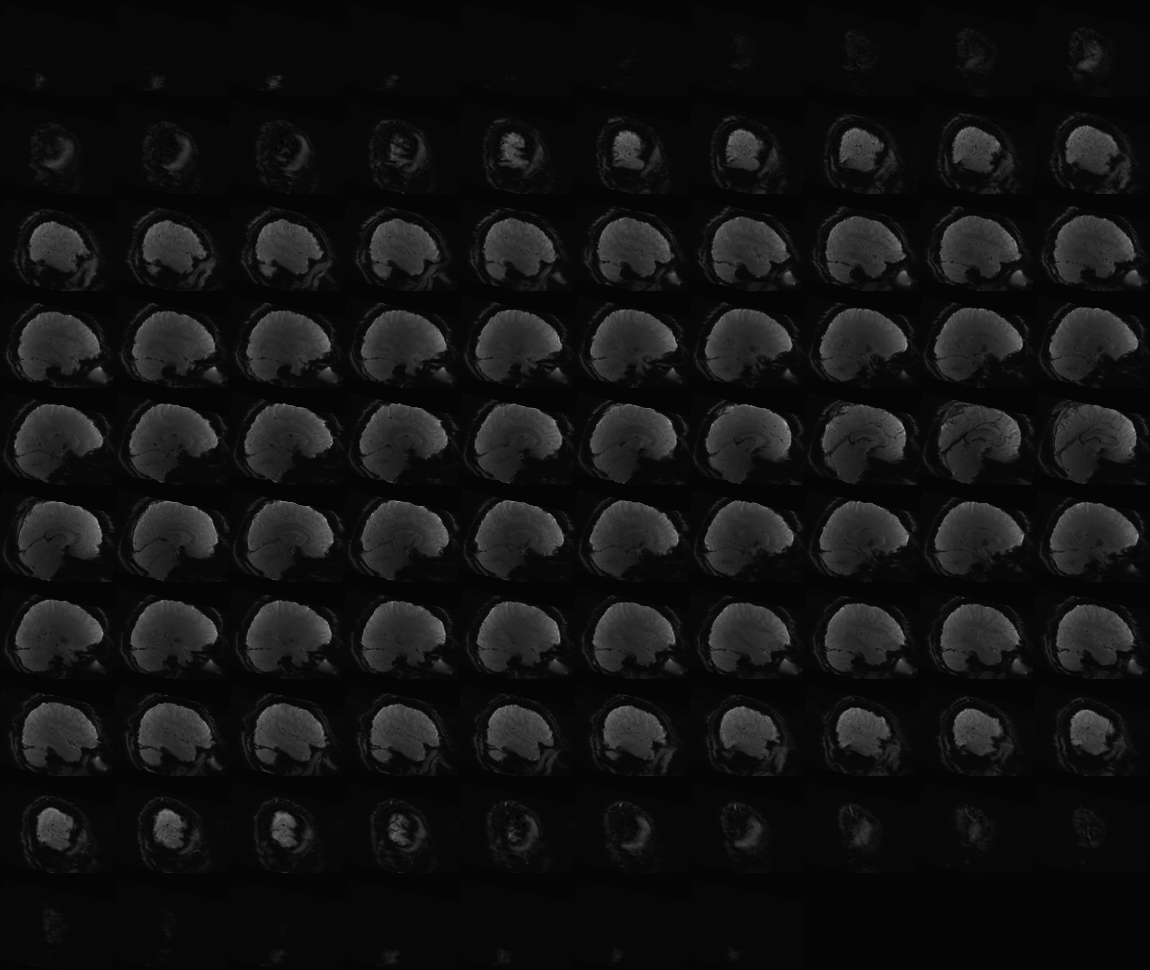
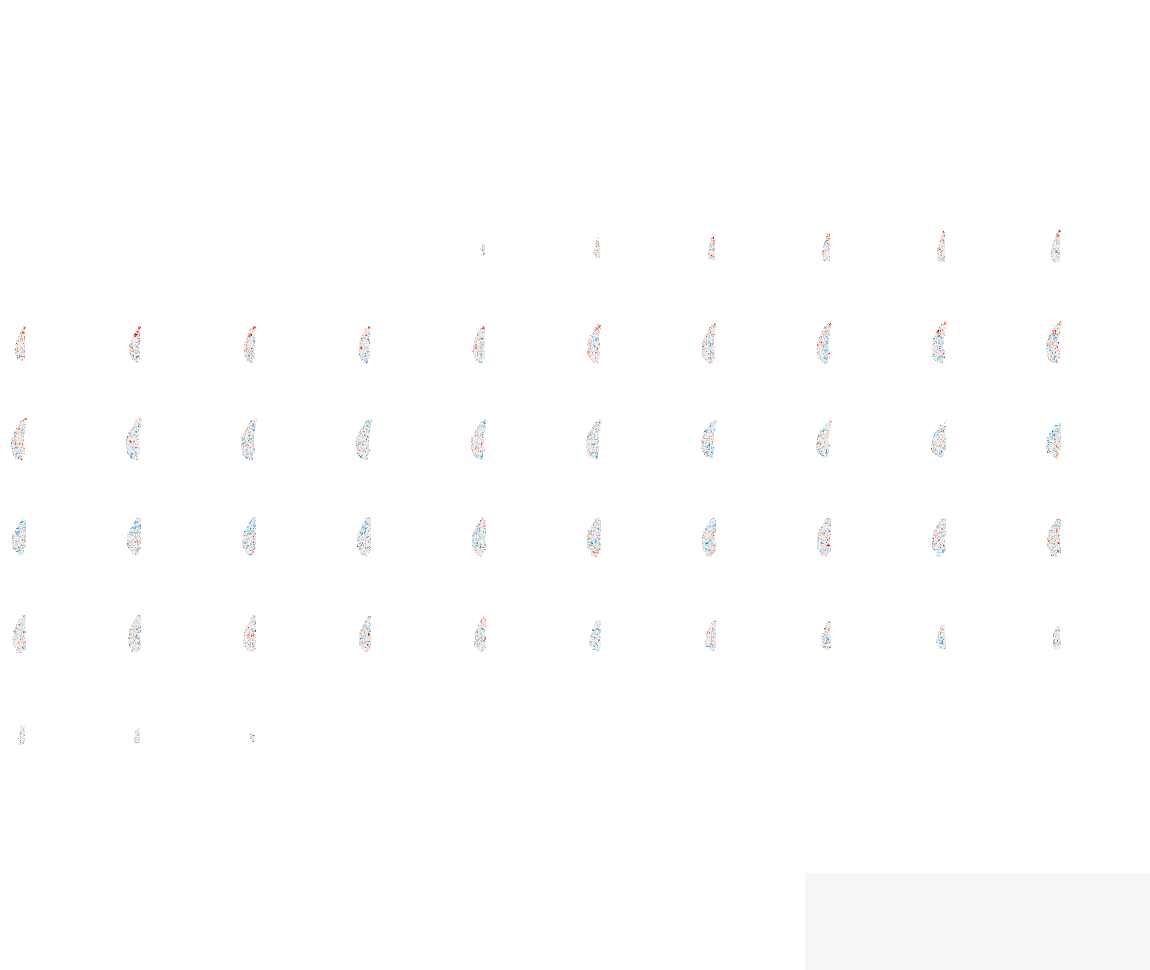

In [41]:
occipital_lobe_results = np.load("zscore_op.npy")
print(occipital_lobe_results.shape)
mask_ = masking.unmask(np.sum(occipital_lobe_results, axis=1), roi_op)
# mask_ = masking.unmask(occipital_lobe_results[:,0], roi_op)

plotting.view_img(mask_, bg_img=mean_flicker, cmap="RdBu_r", threshold=0.0001, black_bg=True, colorbar=True)

(10688, 9)



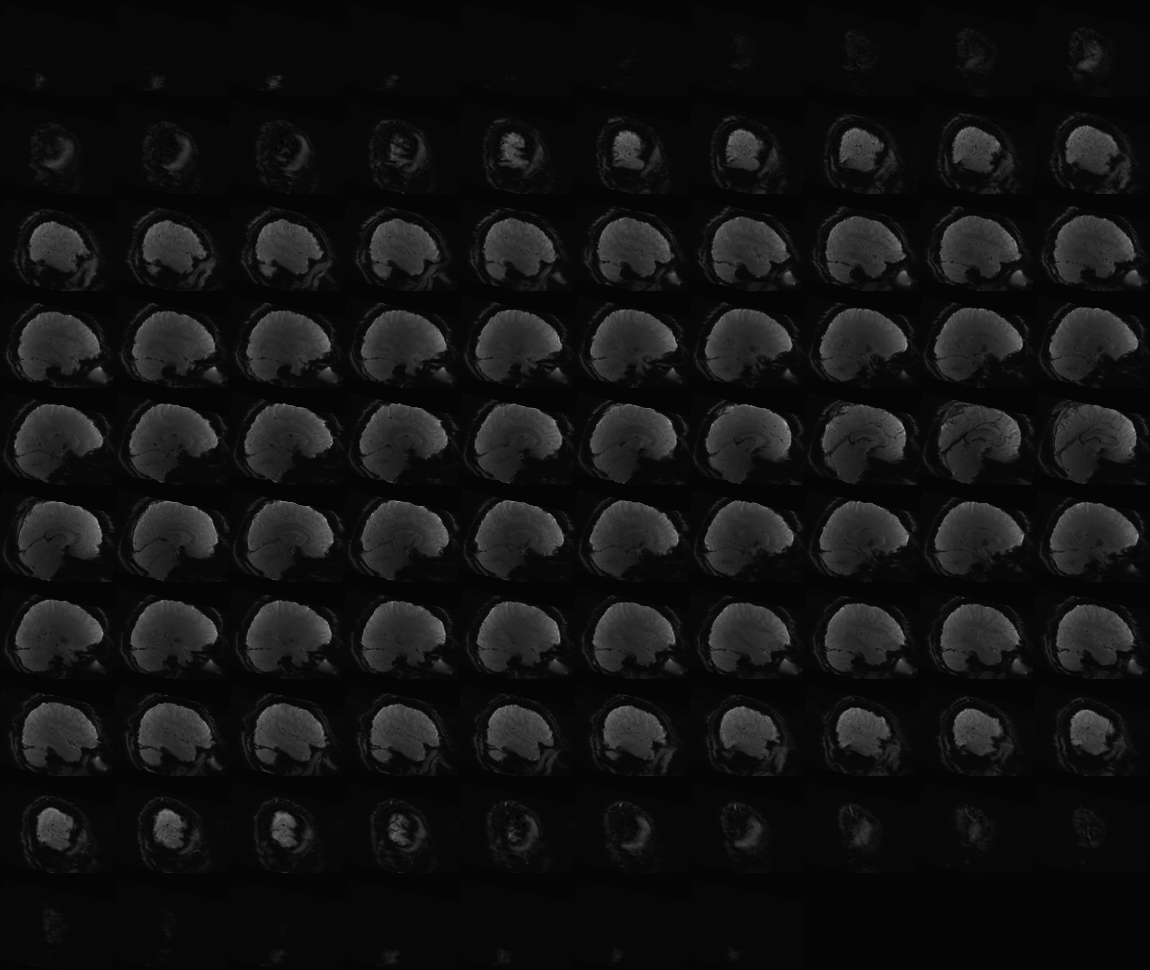
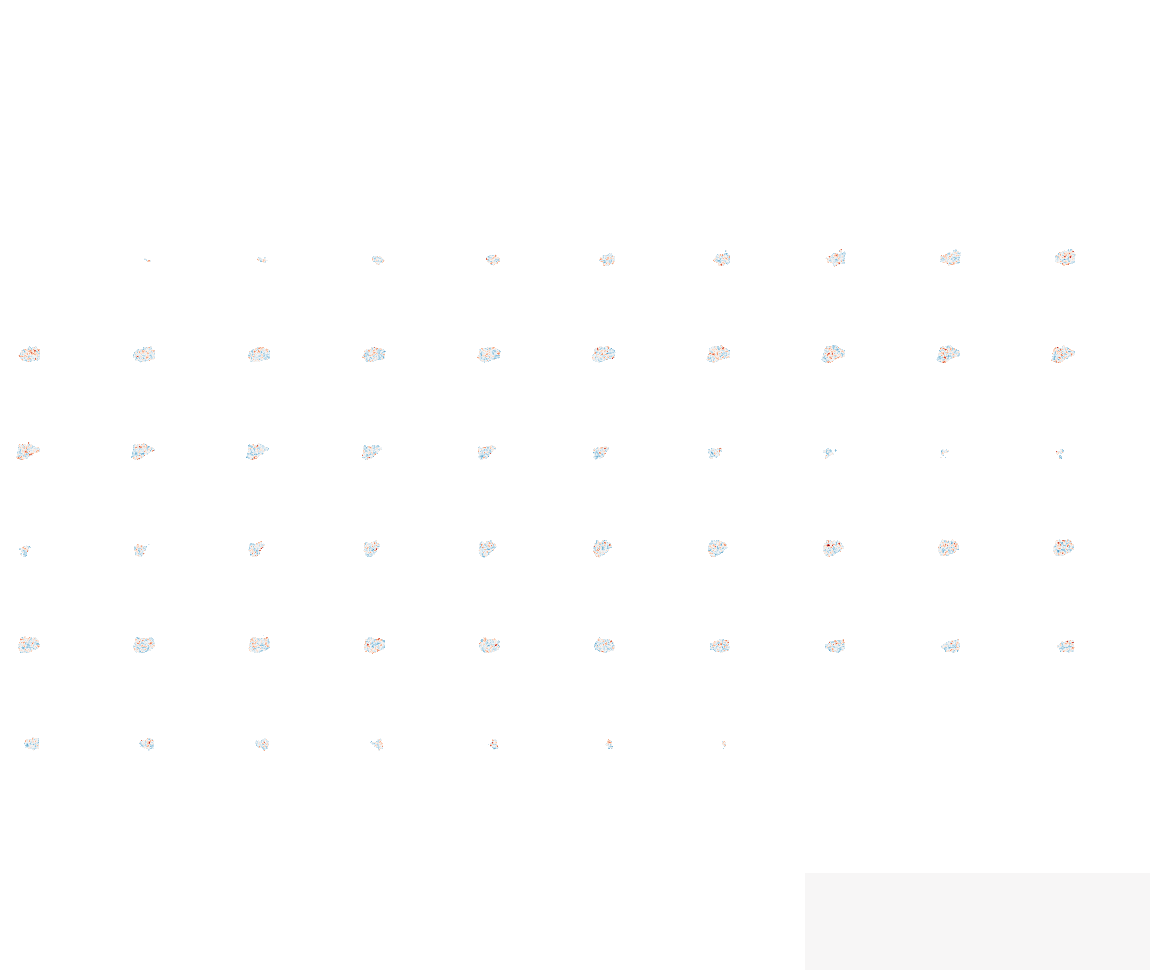

In [60]:
occipital_lobe_results = np.load("zscore_ffg_LS.npy")
print(occipital_lobe_results.shape)
mask_ = masking.unmask(np.sum(occipital_lobe_results, axis=1), roi_ffg)
# mask_ = masking.unmask(occipital_lobe_results[:,0], roi_ffg)

plotting.view_img(mask_, bg_img=mean_flicker, cmap="RdBu_r", threshold=0.00001, black_bg=True, colorbar=True)

(15486, 9)


/home/mszul/miniconda3/envs/mne/lib/python3.9/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



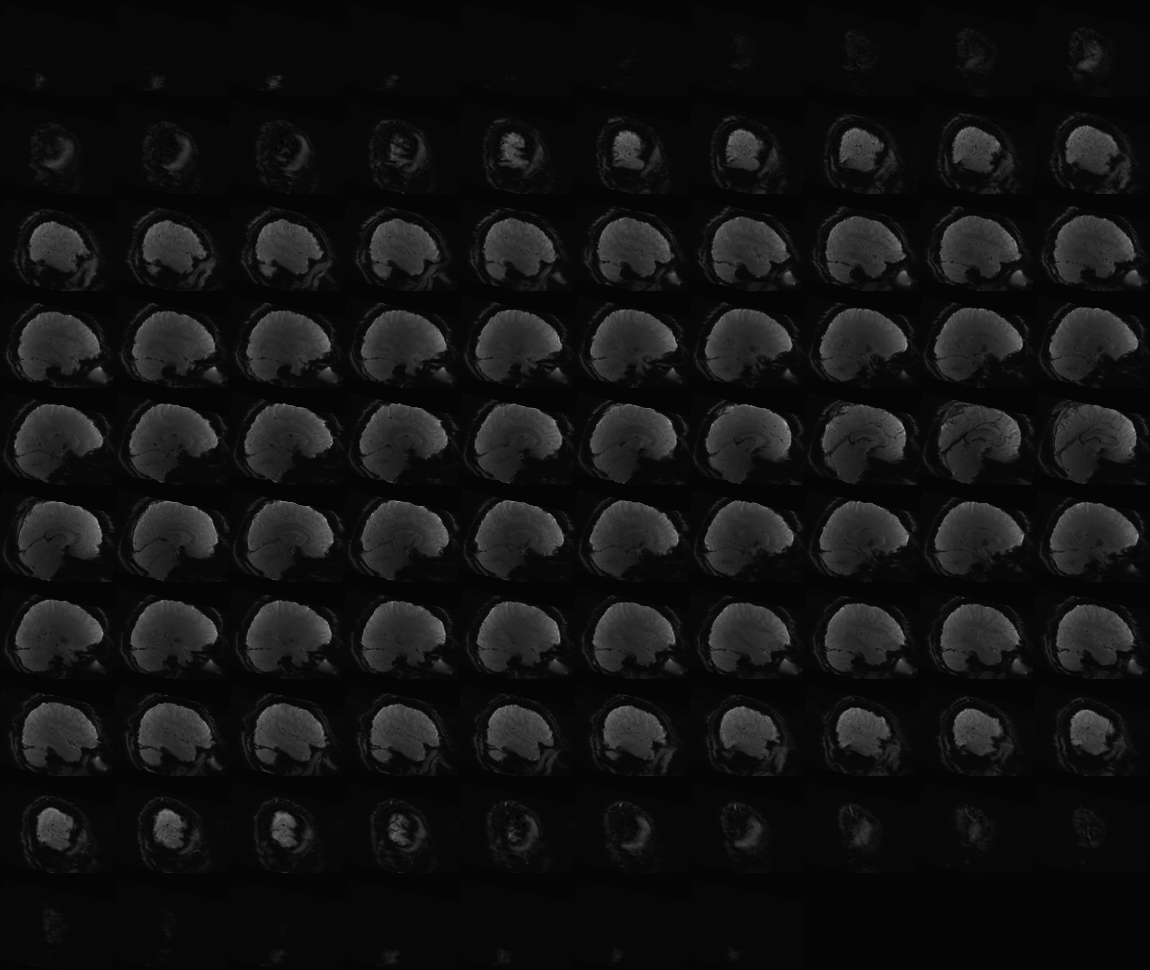
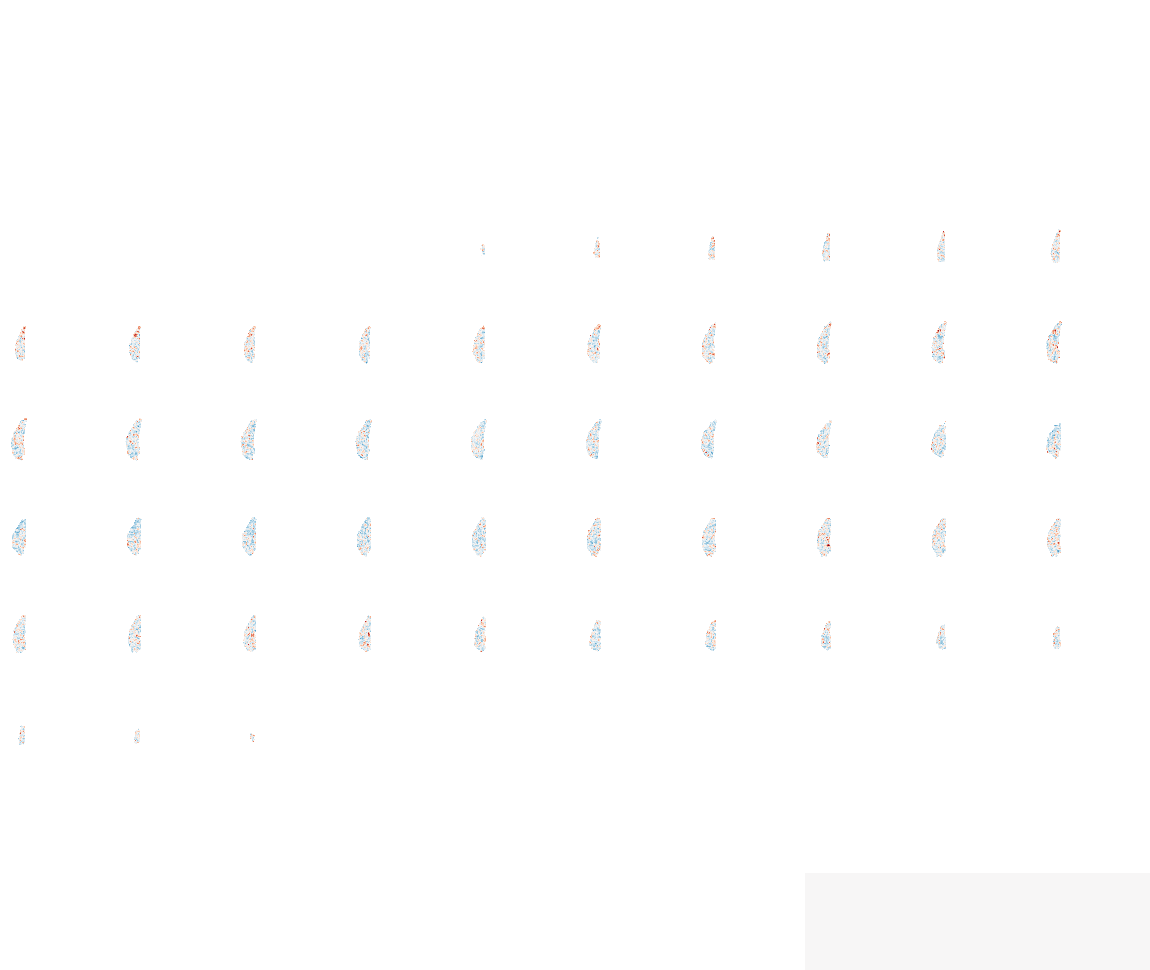

In [40]:
occipital_lobe_results = np.load("zscore_op_LS.npy")
print(occipital_lobe_results.shape)
mask_ = masking.unmask(np.sum(occipital_lobe_results, axis=1), roi_op)
# mask_ = masking.unmask(occipital_lobe_results[:,0], roi_op)

plotting.view_img(mask_, bg_img=mean_flicker, cmap="RdBu_r", threshold=0.0001, black_bg=True, colorbar=True)

In [159]:
sampling_rate = 1/1.3
amount_of_samples = 500
number_of_freq = int(amount_of_samples/2)
zero_padding_size = amount_of_samples*(((sampling_rate/2) / number_of_freq) / 0.0005) / 2
# cur_freq_res = sampling_rate/2 / number_of_freq
# tar_freq_res = 0.0005
# zero_padding_size = int(number_of_freq * (cur_freq_res / tar_freq_res))
print(int(zero_padding_size))

769


In [153]:
amount_of_samples*(((sampling_rate/2) / number_of_freq) / 0.0005) / 2

769.230769230769

In [ ]:
sampling_rate